## **Vision-based angle prediction (SC42050 - Knowledge Based Control Systems)**

# Optionally seed the run, define your model, and fit to the training data 

Loaded observation data: (12120, 28, 28, 3)
Loaded state data: (12120, 2)


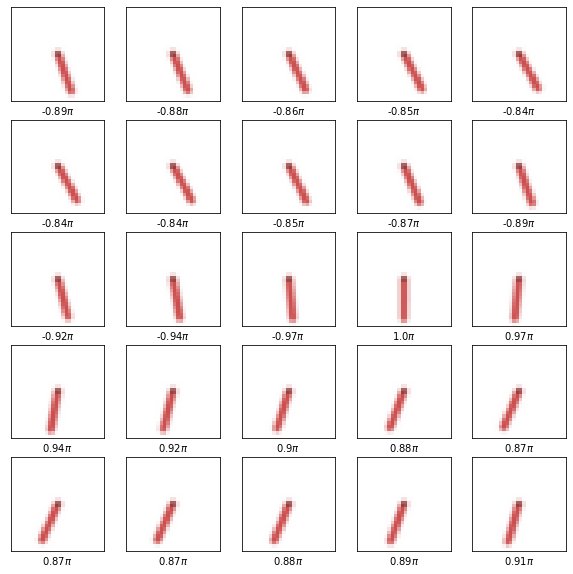

Epoch 1/30
120/120 [==============================] - 3s 26ms/step - loss: 0.0963 - val_loss: 4.4139e-04
Epoch 2/30
120/120 [==============================] - 3s 23ms/step - loss: 3.1670e-04 - val_loss: 2.4627e-04
Epoch 3/30
120/120 [==============================] - 3s 22ms/step - loss: 2.3739e-04 - val_loss: 2.6383e-04
Epoch 4/30
120/120 [==============================] - 3s 23ms/step - loss: 2.0311e-04 - val_loss: 1.6679e-04
Epoch 5/30
120/120 [==============================] - 3s 24ms/step - loss: 1.7018e-04 - val_loss: 1.1664e-04
Epoch 6/30
120/120 [==============================] - 3s 23ms/step - loss: 1.3716e-04 - val_loss: 1.0716e-04
Epoch 7/30
120/120 [==============================] - 3s 22ms/step - loss: 1.2039e-04 - val_loss: 9.0999e-05
Epoch 8/30
120/120 [==============================] - 3s 23ms/step - loss: 1.0757e-04 - val_loss: 7.4017e-05
Epoch 9/30
120/120 [==============================] - 3s 22ms/step - loss: 9.2325e-05 - val_loss: 7.5543e-05
Epoch 10/30
120/120 [==

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import h5py

# FUNCTION TO SEED PSEUDO-RANDOM GENERATORS
def seed_experiment(seed=None, use_cpu=True):
    import os
    # os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    import random
    import numpy as np
    import tensorflow as tf

    # Seed value
    # Apparently you may use different seed values at each stage
    seed_value = seed

    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED'] = str(seed_value)

    # 2. Set `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(seed_value)
    
    # 5. force tensorflow to use CPU
    if use_cpu:
        os.environ['CUDA_VISIBLE_DEVICES'] = ''
    return seed_value

# SEED EXPERIMENT TO CREATE REPRODUCIBLE RESULTS
"""TASK 1.4: PSEUDO-RANDOM GENERATOR"""
seed_value = 0
# seed_experiment(seed=seed_value)  # Comment this line to disable the seeding
"""TASK 1.4: END"""

# USE GPU IF AVAILABLE
gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)

# LOAD DATASET
with h5py.File('./dataset.h5', 'r') as hf:
    observation = hf['observation.h5'][:]
    state = hf['state.h5'][:]
print('Loaded observation data: %s' % str(observation.shape))
print('Loaded state data: %s' % str(state.shape))

# DATASET PARAMETERS
num_examples = 12000
observation = observation[:num_examples]
state = state[:num_examples]

# DATA PRE-PROCESSING
# Scale pixel values to a range of 0 to 1 before feeding them to the neural network model.
observation = observation.astype(np.float32) / 255.

# CREATE TEST DATASET
test_split = 0.2
if 0 < test_split < 1:
    split_at = int(len(observation) * (1 - test_split))
else:
    raise ValueError('Must hold-out data as a test dataset. Set parameter 0 < test_split < 1.')
test_obs = observation[split_at:, :, :, :]
test_theta = state[split_at:, 0]
test_trig = np.hstack([np.sin(test_theta)[:, None], np.cos(test_theta)[:, None]])

# CREATE TRAINING DATASET
train_obs = observation[:split_at, :, :, :]
train_theta = state[:split_at, 0]
train_trig = np.hstack([np.sin(train_theta)[:, None], np.cos(train_theta)[:, None]])

# VERIFY TRAINING DATA
# To verify that the data is in the correct format and that you're ready to build and train the network,
# let's display the first 25 images from the dataset and display the corresponding theta value below each image.
%matplotlib inline
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_obs[i])
    plt.xlabel(str(round(train_theta[i]/np.pi, 2)) + '$\\pi$')
plt.show()

# MODEL PARAMETERS
model_type = 'model_cnn'  # 'model_theta', 'model_trig', 'model_cnn'

# BUILD MODELS
# Building the neural network requires configuring the layers of the model, then compiling the model.
if model_type == 'model_theta':  # Predict theta directly
    """TASK 1.1: CREATE MODEL HERE"""
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(1)
        ]
    )
    """TASK 1.1: END"""
    str_model_type = '$M^\\theta$'
elif model_type == 'model_trig':  # Predict trigonometric functions of theta
    """TASK 1.2: CREATE MODEL HERE"""
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(2)
        ]
    )
    """TASK 1.2: END"""
    str_model_type = '$M^{trig}$'
elif model_type == 'model_cnn':  # Use a CNN
    """TASK 1.3: CREATE MODEL HERE"""
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(2)
        ]
    )
    """TASK 1.3: END"""
    str_model_type = '$M^{cnn}$'
else:
    raise ValueError('Unknown model type selected.')

# VERIFY THAT A MODEL WAS DEFINED
try:
    model
except NameError:
    raise ValueError("Variable 'model' not defined! Make sure to name every keras model 'model'!")

# COMPILE MODEL
"""TASK 1.1: COMPILE MODEL HERE"""
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
"""TASK 1.1: END"""

# FIT MODEL ON DATA
if model_type != 'model_theta':
    """TASK 1.2: TRAIN MODEL HERE"""
    model.fit(
        x=train_obs,
        y=train_trig,
        batch_size=64,
        epochs=30,
        validation_split=0.2,
        shuffle=True,
    )
    """TASK 1.2: END"""
else:
    """TASK 1.1: TRAIN MODEL HERE"""
    model.fit(
        x=train_obs,
        y=train_theta,
        batch_size=64,
        epochs=30,
        validation_split=0.2,
        shuffle=True,
    )
    """TASK 1.1: END"""

# Evaluate your model

75/75 [==============================] - 0s 4ms/step - loss: 5.3482e-06


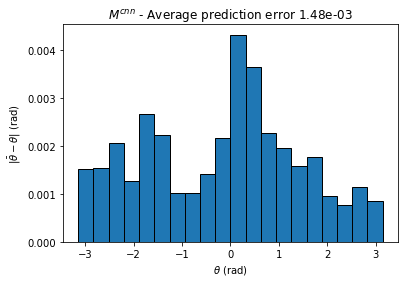

In [20]:
%matplotlib inline

# EVALUATE PERFORMANCE ON TEST DATASET
if model_type != 'model_theta':
    test_scores = model.evaluate(test_obs, test_trig, verbose=1)
    output = model.predict(test_obs)
    pred_theta = np.arctan2(output[:, 0], output[:, 1])
else:
    test_scores = model.evaluate(test_obs, test_theta, verbose=1)
    pred_theta = model.predict(test_obs)[:, 0]
# print("Test loss:", test_scores)

# EVALUATE MODEL ACCURACY
# Calculate average error per bin over theta range [-pi, pi]
test_error = np.abs(test_theta - pred_theta)
test_error[test_error > np.pi] -= 2*np.pi
test_error = np.abs(test_error)
bins = np.linspace(-np.pi, np.pi, 21)
digitized = np.digitize(test_theta, bins)
bin_means = np.array([test_error[digitized == i].mean() for i in range(1, len(bins))])
fig, ax = plt.subplots()
ax.bar(bins[:-1], bin_means, width=np.diff(bins), edgecolor="black", align="edge")
ax.set_xlabel('$\\theta$ (rad)')
ax.set_ylabel('$|\\bar{\\theta} -\\theta|$ (rad)')
ax.set_title('%s - Average prediction error %s' % (str_model_type, '{:.2e}'.format(test_error.mean())));

# Summary of the model

In [21]:
# MODEL SUMMARY
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 10818     
Total params: 11,714
Trainable params: 11,714
Non-trainable params: 0
_________________________________________________________________


# Live simulation (not supported in Google Colab)

In [22]:
import gym
import wrappers
from driver import Driver
from environments.pendulum import UnderactuatedPendulum

%matplotlib qt

# INITIALIZE TEST_PENDULUM ENVIRONMENT
num_sims = 1
len_time = 100
test_env = gym.make('pendulum-underactuated-v0', render_shape=(500, 500), model=model)
test_env = wrappers.NormalizeActions(test_env)
test_env = wrappers.MinimumDuration(test_env, len_time)
test_env = wrappers.MaximumDuration(test_env, len_time)
test_env = wrappers.ObservationDict(test_env, key='observation')
test_env = wrappers.PixelObservations(test_env, (28, 28), np.uint8, 'image')
test_env = wrappers.ConvertRewardToCost(test_env)
test_env = wrappers.ConvertTo32Bit(test_env)
test_env.seed(seed=seed_value)

# INITIALIZE INFRASTRUCTURE
test_driver = Driver(test_env)

# RUN SIMULATOR
print('Test trained model in %d simulations.' % num_sims)
# print('Press "ctrl + c" to interrupt the simulation.')
test_driver.run(render=True, num_steps=len_time*num_sims)
test_env.close()



Test trained model in 1 simulations.
